# Age Estimation using SMOTE

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from glob import glob

import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms, datasets
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset, DataLoader, random_split
from collections import Counter

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image
import shutil

import copy

from pathlib import Path
from datetime import datetime

from torch.utils.tensorboard import SummaryWriter
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from torchvision import transforms
import matplotlib.pyplot as plt

## Age estimation in age groups

### Set image size and variables 

In [3]:
IMAGE_SIZE = [200,200] 
BASE_DIR = './UTKFace/'
NR_EPOCHS = 80
BATCH_SIZE = 30
NUM_CLASSES = 116 

### Split Dataset into validation and test set  

In [4]:
class UTKFaceDataset( ):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = [file for file in os.listdir(root_dir) if file.endswith('.jpg') or file.endswith('.png')]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.images[idx])
        image = Image.open(img_name)
        
        age = int(self.images[idx].split('_')[0])
        
        if self.transform:
            image = self.transform(image)
        
        return image, age

# transform
transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# laod dataset
full_dataset = UTKFaceDataset(root_dir=BASE_DIR, transform=transform)

# split dataset accordingly 
total_size = len(full_dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

# fixed seed for same split across models
generator = torch.Generator().manual_seed(116)

train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, [train_size, val_size, test_size], generator=generator
)

In [5]:
# create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# print size information
print(f"Total dataset size: {total_size}")
print(f"Train set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

Total dataset size: 23708
Train set size: 16595
Validation set size: 3556
Test set size: 3557


### Set cuda if aviable

In [6]:
# check CUDA availability and set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## Base Model

### Create Model

In [7]:
class CNNNet(nn.Module):
    def __init__(self, NUM_CLASSES=117):
        super(CNNNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=7, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(96),

            nn.Conv2d(96, 256, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(256),

            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(384),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.classifier = nn.Sequential(
            nn.Linear(384, 512),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(512, NUM_CLASSES)
        )
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

### SMOTE 

In [8]:
# load model for feature extraction
model = CNNNet(NUM_CLASSES).to(device)
model.load_state_dict(torch.load('./Project/classes/normal/normal_model'))

# remove classifier for feature extraction
model.classifier = torch.nn.Identity() 
model.eval() 

def extract_features(dataloader): 
    features = []
    labels = []
    for images, batch_labels in dataloader:
        with torch.no_grad():
            images = images.to(device)
            model_features = model(images)
            # move to cpu for numpy conversion
            features.append(model_features.to('cpu'))
            labels.append(batch_labels)
    features = torch.cat(features).numpy()
    labels = torch.cat(labels).numpy()

    return features, labels

features_train, labels_train = extract_features(train_loader)
features_val, labels_val = extract_features(val_loader)
features_test, labels_test = extract_features(test_loader)

class_counts = Counter(labels_train)

valid_classes = [classes for classes, count in class_counts.items() if count > 5]
invalid_classes = [classes for classes, count in class_counts.items() if count <= 5]
print("\nValid classes (> 5 samples):", valid_classes)
print("\nInvalid classes (<= 5 samples):", invalid_classes)
invalid_indices = np.isin(labels_train, invalid_classes)
valid_indices = np.isin(labels_train, valid_classes)

filtered_features = features_train[valid_indices]
filtered_labels = labels_train[valid_indices]

invalid_features = features_train[invalid_indices]
invalid_labels = labels_train[invalid_indices]

# use SMOTE only on valid classes
smote = SMOTE(random_state=42)
features_resampled, labels_resampled = smote.fit_resample(filtered_features, filtered_labels)


class FeatureDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.FloatTensor(features)
        self.labels = torch.LongTensor(labels)
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]


final_features = np.concatenate([features_resampled, invalid_features], axis=0)
final_labels = np.concatenate([labels_resampled, invalid_labels], axis=0)

print('\nOriginal class distribution:', class_counts)
print()
print('New class distribution:', Counter(final_labels))

train_dataset_balanced = FeatureDataset(final_features, final_labels)
train_loader_balanced = DataLoader(train_dataset_balanced, batch_size=BATCH_SIZE, shuffle=True)

val_dataset = FeatureDataset(features_val, labels_val)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

test_dataset = FeatureDataset(features_test, labels_test)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

model.classifier = nn.Sequential(
    nn.Linear(384, 512),
    nn.ReLU(),
    nn.Dropout(0.25),
    nn.Linear(512, 512),
    nn.ReLU(),
    nn.Dropout(0.25),
    nn.Linear(512, NUM_CLASSES)
).to(device)



Valid classes (> 5 samples): [26, 63, 4, 30, 15, 29, 31, 24, 54, 14, 25, 28, 10, 32, 27, 3, 22, 36, 38, 7, 58, 70, 75, 62, 1, 85, 2, 74, 64, 33, 41, 37, 66, 21, 56, 5, 73, 23, 6, 20, 61, 39, 44, 40, 60, 48, 45, 51, 18, 42, 35, 72, 16, 82, 50, 8, 17, 69, 47, 80, 9, 89, 65, 71, 43, 34, 52, 53, 68, 67, 55, 13, 49, 90, 12, 11, 57, 59, 46, 86, 88, 78, 87, 19, 84, 77, 76, 83, 100, 79, 92, 81, 96]

Invalid classes (<= 5 samples): [115, 105, 99, 95, 116, 93, 101, 110, 91, 103, 111]

Original class distribution: Counter({26: 1519, 1: 800, 28: 644, 35: 626, 24: 586, 25: 511, 30: 506, 32: 460, 27: 426, 29: 398, 40: 366, 36: 335, 2: 324, 45: 307, 23: 298, 34: 284, 22: 269, 50: 266, 54: 247, 31: 246, 21: 244, 38: 228, 3: 220, 60: 216, 4: 207, 37: 203, 20: 198, 39: 192, 8: 189, 42: 188, 58: 187, 18: 184, 16: 182, 55: 178, 65: 176, 53: 167, 56: 163, 52: 150, 5: 141, 9: 124, 75: 123, 15: 117, 49: 117, 43: 116, 47: 114, 14: 112, 17: 111, 61: 110, 48: 109, 85: 105, 33: 103, 10: 102, 7: 102, 70: 102, 46

In [9]:
# since features are extractet use classifier only for training
class ClassifierNet(nn.Module):
    def __init__(self, num_classes):
        super(ClassifierNet, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(384, 512),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, x):
        return self.classifier(x)

model = ClassifierNet(NUM_CLASSES).to(device)

In [10]:
writer = SummaryWriter('./Project/class_imbalance/runs/smote', comment='Smote_Class_Model')

In [11]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001)
loss_fn = torch.nn.CrossEntropyLoss()
loss_fn = loss_fn.to(device)

# define age_classes tensor
age_classes = torch.tensor([i for i in range(0, NUM_CLASSES)]).to(device)

### Train model

In [12]:
def train(model, optimizer, loss_fn, train_loader, val_loader, epochs, summary_writer, device, save_path):
    
    # create history for graphs
    history = {
        'loss': [],
        'val_loss': [],
        'accuracy': [],
        'val_accuracy': [],
        'mae': [],
        'val_mae': []
    }
    # create cuda events for timetracking
    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)
    
    # init variables for saving
    best_val_mae = float('Inf') 
    best_model_wts = copy.deepcopy(model.state_dict()) 
    
    start.record()
    for epoch in range(epochs):
        training_loss = 0.0
        valid_loss = 0.0
        num_train = 0
        num_train_correct = 0
        total_train_mae = 0.0
        total_val_mae = 0.0
        
        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            inputs, targets = batch
            # shift labels from 1-116 to 0-115 for loss
            targets_model = targets - 1
            inputs, targets_model = inputs.to(device), targets_model.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            
            loss = loss_fn(outputs, targets_model)
            loss.backward()
            optimizer.step()
            training_loss += loss.item()
            _, predicted = outputs.max(1)
            predicted = predicted + 1
            num_train += targets.size(0)
            num_train_correct += predicted.eq(targets).sum().item()

            probabilities = F.softmax(outputs, dim=1)
            expected_age = torch.sum(probabilities * age_classes, dim=1) + 1
            total_train_mae += torch.abs(expected_age - targets.float()).sum().item()
                  
        training_loss /= len(train_loader)
        train_accuracy = num_train_correct / num_train
        train_mae = total_train_mae / num_train

        if epoch+1 == NR_EPOCHS:
            end.record()
            torch.cuda.synchronize()
        
        model.eval()
        num_val = 0
        num_val_correct = 0
        with torch.no_grad():
            for batch in val_loader:
                inputs, targets = batch
                # shift labels from 1-116 to 0-115 for loss
                targets_model = targets - 1
                inputs, targets_model = inputs.to(device), targets_model.to(device)
                targets = targets.to(device)
                outputs = model(inputs)
                
                loss = loss_fn(outputs, targets_model)
                valid_loss += loss.item()
                _, predicted = outputs.max(1)
                predicted = predicted + 1
                num_val += targets.size(0)
                num_val_correct += predicted.eq(targets).sum().item() 

                probabilities = F.softmax(outputs, dim=1)
                expected_age = torch.sum(probabilities * age_classes, dim=1) + 1
                total_val_mae += torch.abs(expected_age - targets.float()).sum().item()
        
        valid_loss /= len(val_loader)
        val_accuracy = num_val_correct / num_val
        val_mae = total_val_mae / num_val

        summary_writer.add_scalar('Train Loss', training_loss, epoch+1)
        summary_writer.add_scalar('Val Loss', valid_loss, epoch+1)
        summary_writer.add_scalar('Accuracy', train_accuracy, epoch+1)
        summary_writer.add_scalar('Validation Accuracy', val_accuracy, epoch+1)
        summary_writer.add_scalar('Train MAE', train_mae, epoch+1)
        summary_writer.add_scalar('Val MAE', val_mae, epoch+1)
    
        history['loss'].append(training_loss)
        history['val_loss'].append(valid_loss)
        history['accuracy'].append(train_accuracy)
        history['val_accuracy'].append(val_accuracy)
        history['mae'].append(train_mae)
        history['val_mae'].append(val_mae)

        print(f'Epoch [{epoch+1}/{NR_EPOCHS}], Training Loss: {training_loss:.2f}, Validation Loss: {valid_loss:.2f}, '
              f'Training Accuracy: {train_accuracy:.2f}, Validation Accuracy: {val_accuracy:.2f}, Training MAE: {train_mae:.2f}, Validation MAE: {val_mae:.2f}')
        
        if val_mae < best_val_mae:
            best_val_mae = val_mae
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(best_model_wts, save_path)
            print(f"Best model saved at epoch {epoch+1} with validation MAE: {best_val_mae:.2f}")

    print(f'Training time:  {round(start.elapsed_time(end), 1) / 60000} minutes')    
    return history

In [13]:
history = train(model, optimizer, loss_fn, train_loader_balanced, val_loader, NR_EPOCHS, writer, device, './Project/class_imbalance/smote/smote_model')
writer.close()

Epoch [1/80], Training Loss: 4.75, Validation Loss: 4.75, Training Accuracy: 0.01, Validation Accuracy: 0.01, Training MAE: 24.80, Validation MAE: 27.99
Best model saved at epoch 1 with validation MAE: 27.99
Epoch [2/80], Training Loss: 4.75, Validation Loss: 4.75, Training Accuracy: 0.01, Validation Accuracy: 0.01, Training MAE: 24.76, Validation MAE: 27.89
Best model saved at epoch 2 with validation MAE: 27.89
Epoch [3/80], Training Loss: 4.74, Validation Loss: 4.74, Training Accuracy: 0.01, Validation Accuracy: 0.01, Training MAE: 24.72, Validation MAE: 27.79
Best model saved at epoch 3 with validation MAE: 27.79
Epoch [4/80], Training Loss: 4.74, Validation Loss: 4.74, Training Accuracy: 0.02, Validation Accuracy: 0.01, Training MAE: 24.67, Validation MAE: 27.69
Best model saved at epoch 4 with validation MAE: 27.69
Epoch [5/80], Training Loss: 4.73, Validation Loss: 4.73, Training Accuracy: 0.02, Validation Accuracy: 0.01, Training MAE: 24.63, Validation MAE: 27.58
Best model save

## Training Histories

In [14]:
def plot_history(history, path_name):
    # loss
    loss_train = history['loss']
    loss_val = history['val_loss']
    epochs = range(NR_EPOCHS)
    plt.plot(epochs, loss_train, 'g', label='Training loss')
    plt.plot(epochs, loss_val, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    plt.savefig(path_name + '_loss.png', bbox_inches='tight')

    # accuracy
    accuracy_train = history['accuracy']
    accuracy_val = history['val_accuracy']
    epochs = range(NR_EPOCHS)
    plt.plot(epochs, accuracy_train, 'g', label='Training accuracy')
    plt.plot(epochs, accuracy_val, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig(path_name + '_accuracy.png', bbox_inches='tight')
    plt.show()

     # MAE
    accuracy_train = history['mae']
    accuracy_val = history['val_mae']
    epochs = range(NR_EPOCHS)
    plt.plot(epochs, accuracy_train, 'g', label='Training MAE')
    plt.plot(epochs, accuracy_val, 'b', label='Validation MAE')
    plt.title('Training and validation MAE')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig(path_name + '_mae.png', bbox_inches='tight')
    plt.show()
    

### History of normal model

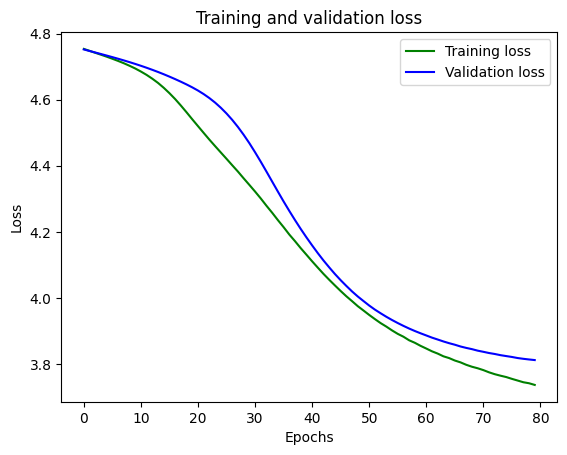

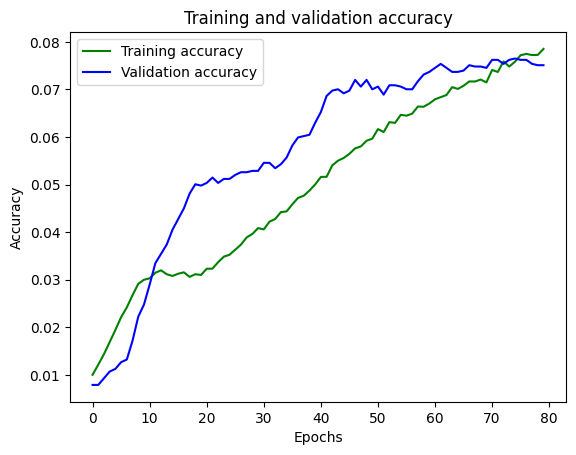

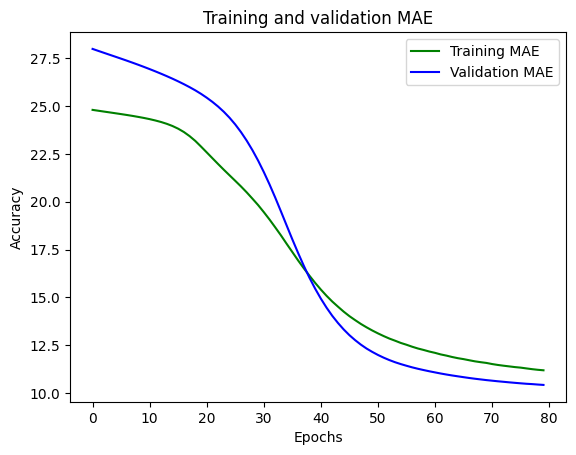

In [15]:
plot_history(history, './Project/class_imbalance/smote/smote')

## Test models

In [16]:
def test(model, test_loader, loss_fn, name):
    test_loss = 0
    test_correct = 0
    test_total = 0
    total_test_mae = 0
    
    # create cuda events for timetracking
    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)

    start.record()
    with torch.no_grad():
        for inputs, labels in test_loader:
            # shift labels from 1-116 to 0-115 for loss
            labels_model = labels - 1
            inputs, labels_model = inputs.to(device), labels_model.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, labels_model)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            predicted = predicted + 1
            test_total += labels.size(0)
            test_correct += predicted.eq(labels).sum().item()

            probabilities = F.softmax(outputs, dim=1)
            expected_age = torch.sum(probabilities * age_classes, dim=1) + 1
            total_test_mae += torch.abs(expected_age - labels.float()).sum().item()   

    end.record()
    torch.cuda.synchronize()
    test_loss = test_loss / len(test_loader)
    test_accuracy = test_correct / test_total
    test_mae = total_test_mae / test_total

    print(f'Model: {name},  Test Loss: {test_loss:.2f}, Test Accuracy: {test_accuracy:.2f}, Test MAE: {test_mae:.2f}')
    print(f'Time:  {round(start.elapsed_time(end), 1) / 1000} seconds')

In [17]:
### Benchmarks

In [18]:
# load models
model_test = ClassifierNet(NUM_CLASSES).to(device)
model_test.load_state_dict(torch.load('./Project/class_imbalance/smote/smote_model'))
print("-----------------------------------------------------------------------")

test(model_test, test_loader, loss_fn, 'Normal SMOTE Features CNN')

-----------------------------------------------------------------------
Model: Normal SMOTE Features CNN,  Test Loss: 3.88, Test Accuracy: 0.06, Test MAE: 10.82
Time:  0.10690000000000001 seconds
